# Setup

In [ ]:
import talib as ta
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pickle
from tiingo import TiingoClient
import financedatabase as fd
import datetime
import financetoolkit
from utils.api_keys import API_KEYS
import zipfile
import requests

# Format setup
# setting date format


# Tiingo

We use the [supported tickers by Tiingo](https://www.tiingo.com/documentation/end-of-day#:~:text=supported_tickers.zip) to select ETFs that are still listed on the following: 
*   Nasdaq
*   NYSE
*   BATS

The ETFs must be traded prior to 2018 and still be active.

We add 60 trading "warm-up" days prior to the start date of 2018 to ensure that we have enough data to calculate the lagged returns, volatility and other technical indicators.

This selection of ETFs resulted in a list of 1789 ETFs.

In [ ]:
# Download the Tiingo supported tickers file from the URL
tiingo_zip_url = 'https://apimedia.tiingo.com/docs/tiingo/daily/supported_tickers.zip'
#unzip the file
tiingo_zip_path = 'supported_tickers.zip'
# Download the zip file
response = requests.get(tiingo_zip_url)
with open(tiingo_zip_path, 'wb') as f:
    f.write(response.content)
# Unzip the file
with zipfile.ZipFile(tiingo_zip_path, 'r') as zip_ref:
    zip_ref.extractall('.')
 
# Read the CSV file
supported_tickers_df = pd.read_csv(tiingo_zip_path)
# Filter the DataFrame to include only ETFs
etfs_df = supported_tickers_df[supported_tickers_df['assetType'] == 'ETF']
etfs_df.head()

,ticker,exchange,assetType,priceCurrency,startDate,endDate
1621,0040,NaN,ETF,USD,NaN,NaN
1622,0045,NMFQS,ETF,USD,NaN,NaN
1727,159636,SHE,ETF,CNY,2022-07-20,2025-05-16
3734,515120,SHG,ETF,CNY,2021-01-04,2025-05-16
3748,515290,SHG,ETF,CNY,2020-12-28,2025-05-16


In [25]:
 # Setting the ETF filters
exchange_filter = ['NYSE', 'NYSE ARCA', 'NYSE MKT', 'NASDAQ', 'BATS']
startDate_filter = pd.to_datetime('2018-01-01')
endDate_filter = pd.to_datetime('2025-04-23')
# Setting the warmup period
warmup_period = int(60 *1.4) # 60 approx 60 trading days
warmup_start = startDate_filter - pd.Timedelta(days=warmup_period)
# Convert the startDate and endDate columns to datetime
etfs_df['startDate'] = pd.to_datetime(etfs_df['startDate'])
etfs_df['endDate'] = pd.to_datetime(etfs_df['endDate'])

# Filter the DataFrame to include only the tickers that are not delisted
etfs_df = etfs_df[etfs_df['endDate'] >= endDate_filter]
# Filter the DataFrame to include only the tickers traded prior to 2018
etfs_df = etfs_df[etfs_df['startDate'] <= warmup_start]
# Filter the DataFrame to include only the tickers traded on NYSE, NASDAQ or BATS
etfs_df = etfs_df[etfs_df['exchange'].isin(exchange_filter)]
# return the tickers
etf_tickers = etfs_df['ticker'].tolist()
# Display the number of tickers
print(f"Number of ETFs: {len(etf_tickers)}")
# display the first 10 tickers
print("First 10 ETF tickers:")
print(etf_tickers[:10])


Number of ETFs: 1735
First 10 ETF tickers:
['AADR', 'AAVM', 'AAXJ', 'ABFL', 'ABLG', 'ACP', 'ACSI', 'ACV', 'ACWI', 'ACWV']


# Sector indentification with Finance Database

We will use the [Finance Database](https://github.com/JerBouma/FinanceDatabase) package to identify the sector and industry of the ETFs, as this information is available for stocks only on Tiingo.

In [15]:
#Initialize the financedatabase ETFs Data
etfs = fd.ETFs()
etfs_data = etfs.data
etfs_data

,name,currency,summary,category_group,category,family,exchange
symbol,,,,,,,
^ACWI,ISHARES TRUST,USD,The iShares MSCI ACWI ETF seeks to track the i...,Financials,Developed Markets,BlackRock Asset Management,NIM
^ADFI-IV,NFIELD DYNAMIC FIXED INCOME ETF,USD,The NFIELD DYNAMIC FIXED INCOME ETF (ADFI) is ...,Fixed Income,Corporate Bonds,NaN,ASE
^ADRE,INVESCO ACTIVELY M,USD,The Invesco Active REIT ETF is an actively man...,Real Estate,REITs,Invesco Investment Management,NIM
^ARB-EU,ALTSHARES MERGER ARBITRAGE ETF,USD,The ALTSHARES MERGER ARBITRAGE ETF seeks capit...,Alternatives,NaN,AltShares,ASE
^ARB-IV,ALTSHARES MERGER ARBITRAGE ETF,USD,The ALTSHARES MERGER ARBITRAGE ETF seeks capit...,Alternatives,NaN,AltShares,ASE
...,...,...,...,...,...,...,...
VGFPF,Vanguard Funds Public Limited Company - Vangua...,NaN,The Vanguard S&P 500 UCITS ETF (USD) Accumulat...,Equities,NaN,NaN,NaN
VFDEF,Vanguard Funds Public Limited Company - Vangua...,NaN,VFDEF is an exchange-traded fund (ETF) that ai...,Equities,NaN,NaN,NaN
WSDMF,WisdomTree Issuer ICAV - WisdomTree Europe Equ...,NaN,The WisdomTree Issuer ICAV - WisdomTree Europe...,Equities,NaN,NaN,NaN


In [16]:
# Build dictionnary for sector, industry and category
etf_sector_info = {}

# For each selected Ticker, get the sector, industry and category
enriched_etfs = []
for ticker in etf_tickers:
    # Look for additional information in financedatabase
    # we may need to handle suffixes (ex: adding .US)
    if ticker in etfs_data.index:
        etf_info = etfs_data.loc[ticker]
        enriched_etfs.append({
            'ticker': ticker,
            'name': etf_info['name'] if 'name' in etf_info else 'N/A',
            'sector': etf_info['category_group'] if 'category_group' in etf_info else 'N/A',
            'industry': etf_info['category'] if 'category' in etf_info else 'N/A'
        })
    else:
        # Try other formats
        alt_ticker = ticker + '.US'
        if alt_ticker in etfs_data:
            etf_info = etfs_data.loc[alt_ticker]
            enriched_etfs.append({
                'ticker': ticker,
                'name': etf_info.get('name', 'N/A'),
                'sector': etf_info.get('category_group', 'N/A'),
                'industry': etf_info['category'] if 'category' in etf_info else 'N/A'
            })
        else:
            # Ticker not found in financedatabase, add a placeholder
            enriched_etfs.append({
                'ticker': ticker,
                'name': 'N/A',
                'sector': 'N/A',
                'industry': 'N/A',
                'category': 'N/A'
            })

# Build a DataFrame from the enriched ETFs list
enriched_etfs_df = pd.DataFrame(enriched_etfs)

# Filter the DataFrame to include only ETFs with sector, industry or category containing 'Technology'
tech_etfs_df = enriched_etfs_df[
                                (enriched_etfs_df['sector'].str.contains('Technology', na=False)) |
                                (enriched_etfs_df['industry'].str.contains('Technology', na=False))
                                ].reset_index(drop=True)                           

# Afficher le résultat
print(f"Tech ETFs found: {len(tech_etfs_df)}")
tech_etfs_df.head()

Tech ETFs found: 72


,ticker,name,sector,industry,category
0,ARKK,ARK Innovation ETF,Information Technology,Factors,NaN
1,ARKQ,ARK Autonomous Technology & Robotics ETF,Industrials,Technology,NaN
2,ARKW,ARK Next Generation Internet ETF,Information Technology,Technology,NaN
3,CIBR,First Trust NASDAQ Cybersecurity ETF,Information Technology,Technology,NaN
4,CQQQ,Invesco China Technology ETF,Information Technology,Emerging Markets,NaN


In [17]:
tech_etfs_list = tech_etfs_df['ticker'].tolist()

# Importing Data from Tiingo

With our asset universe of 75 ETFs constructed, we will use the Tiingo API to download the historical data for these ETFs.

In [26]:
tiingo_api = API_KEYS['tiingo']
config = {}
config['session'] = True
config['api_key'] = tiingo_api
# Create a Tiingo client
tiingo_client = TiingoClient(config)

# Set the start and end dates for the data
tiingo_start_date = str(warmup_start.date())
tiingo_end_date = str(endDate_filter.date())
# Set the frequency for the data
frequency = 'daily'
# Get the data for the ETFs
etf_data = {}
for ticker in tech_etfs_list:
    try:
        # Fetch historical data for the ETF
        data = tiingo_client.get_dataframe(ticker, columns='adjClose,adjHigh,adjLow,adjOpen,adjVolume', startDate=tiingo_start_date, endDate=tiingo_end_date, frequency=frequency)
        # Store the data in the dictionary
        etf_data[ticker] = data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Save the data to a pickle file
with open('etf_data.pkl', 'wb') as f:
    pickle.dump(etf_data, f)


In [27]:
# load the data from the pickle file
with open('etf_data.pkl', 'rb') as f:
    etf_historical = pickle.load(f)
# Display the first 5 rows of the historical data for the first ETF
etf_historical[list(etf_historical.keys())[0]].head()

,adjClose,adjHigh,adjLow,adjOpen,adjVolume
date,,,,,
2017-10-09 00:00:00+00:00,32.310719,32.628217,32.267634,32.628217,80035
2017-10-10 00:00:00+00:00,32.165930,32.581989,31.934787,32.581989,103868
2017-10-11 00:00:00+00:00,32.184422,32.267634,32.073011,32.230651,93069
2017-10-12 00:00:00+00:00,32.286125,32.406320,32.165653,32.276879,167089
2017-10-13 00:00:00+00:00,32.161308,32.489531,32.036490,32.489531,82735


We succesfully loaded data from 2017-10-09 to 2025-04-23 for the 75 ETFs.

# Cleaning the Data

To clean the data we will:
*   Remove any ETFs with missing data
*   Remove any ETFs with a price of 0
*   Remove any ETFs with no liquidity

In [28]:
# Count tickers with nan values
nan_tickers = []
for ticker, data in etf_historical.items():
    if data.isnull().any().any():
        nan_tickers.append(ticker)
        
print(f"Number of tickers with NaN values: {len(nan_tickers)}")
if len(nan_tickers) > 0:
    print("\nTickers with NaN values:")
    for ticker in nan_tickers:
        print(f"- {ticker}")
        

Number of tickers with NaN values: 0


In [29]:
# Removing any ETFs with a price of 0
etfs_to_remove = []
for ticker, data in etf_historical.items():
    if (data['adjClose'] == 0).any():
        etfs_to_remove.append(ticker)
print(f"Number of tickers with a price of 0: {len(etfs_to_remove)}")

Number of tickers with a price of 0: 0


In [30]:
# Number of ETFS
print(f"Number of ETFs in the dataset: {len(etf_historical)}")
# Counting number of days with no volume
days_no_volume = {}
for ticker, data in etf_historical.items():
    days_no_volume[ticker] = (data['adjVolume'] == 0).sum()

print("\nNumber of days with no volume per ETF:")
for ticker, days in days_no_volume.items():
    if days > 0:
        print(f"- {ticker}: {days} days")

# Remove ETFs that were untraded for more than 3 days
etfs_to_remove = [ticker for ticker, days in days_no_volume.items() if days > 3]
for ticker in etfs_to_remove:
    del etf_historical[ticker]
print(f"\nRemoved {len(etfs_to_remove)} illiquid ETFs")

print(f"Remaining ETFs in the dataset: {len(etf_historical)}")

Number of ETFs in the dataset: 72

Number of days with no volume per ETF:
- IDMO: 199 days
- ISMD: 1 days
- LRGE: 73 days
- NXTG: 3 days

Removed 2 illiquid ETFs
Remaining ETFs in the dataset: 70


Volume Distribution Statistics:
       Average Daily Volume
count          7.000000e+01
mean           4.302356e+06
std            1.427198e+07
min            3.746419e+03
25%            4.356964e+04
50%            1.683481e+05
75%            5.240637e+05
max            9.841973e+07

Number of ETFs with low liquidity (bottom 5%): 4


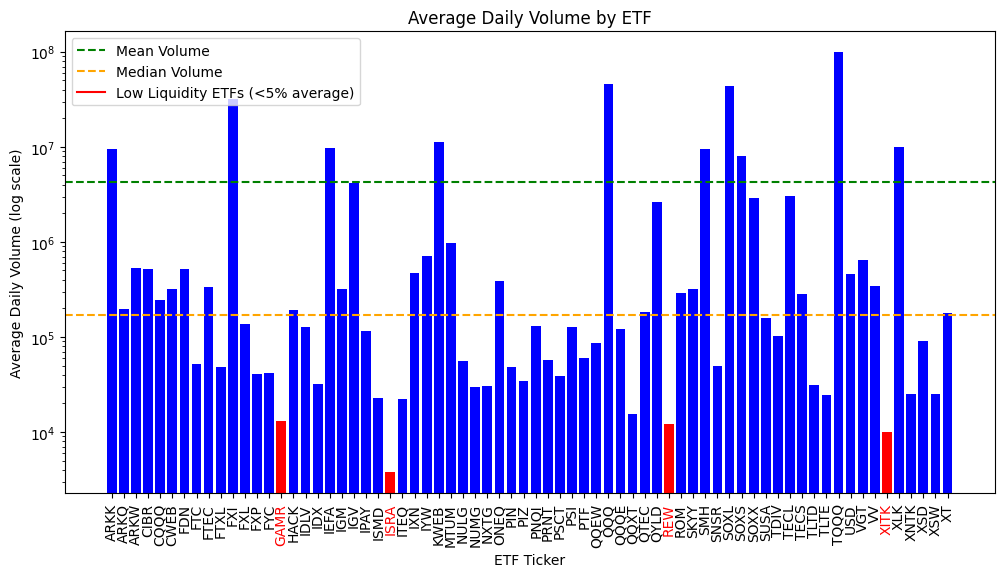

In [31]:
# Calculate average daily volume for each ETF
avg_volumes = {}
for ticker, data in etf_historical.items():
    avg_volumes[ticker] = data['adjVolume'].mean()

# Convert to DataFrame for analysis
volume_df = pd.DataFrame.from_dict(avg_volumes, orient='index', columns=['Average Daily Volume'])

# Calculate volume distribution statistics
print("Volume Distribution Statistics:")
print(volume_df.describe())

# Identify low liquidity ETFs (bottom 5% by volume)
volume_threshold = volume_df['Average Daily Volume'].quantile(0.05)
low_liquidity_etfs = volume_df[volume_df['Average Daily Volume'] < volume_threshold].index.tolist()

print(f"\nNumber of ETFs with low liquidity (bottom 5%): {len(low_liquidity_etfs)}")

# Plot volume distribution bar plot
plt.figure(figsize=(12,6))

# Create bar colors based on liquidity
colors = ['red' if ticker in low_liquidity_etfs else 'blue' for ticker in volume_df.index]
plt.bar(volume_df.index, volume_df['Average Daily Volume'], color=colors)

plt.yscale('log')
plt.axhline(y=volume_df['Average Daily Volume'].mean(), color='green', linestyle='--', label='Mean Volume')
plt.axhline(y=volume_df['Average Daily Volume'].median(), color='orange', linestyle='--', label='Median Volume')
plt.title('Average Daily Volume by ETF')
plt.ylabel('Average Daily Volume (log scale)')
plt.xlabel('ETF Ticker')

# Color x-axis tickers based on liquidity
ax = plt.gca()
xticks = ax.get_xticklabels()
for i, tick in enumerate(xticks):
    if volume_df.index[i] in low_liquidity_etfs:
        tick.set_color('red')
plt.xticks(rotation=90)

# Add low liquidity ETFs to legend
plt.plot([], [], color='red', label='Low Liquidity ETFs (<5% average)')
plt.legend()
plt.show()

# Adding the Technical Indicators

We will populate the data with technical analysis features as in Roychoudhury (2021).

To lighten the number of features, we will use fibonacci periods to calculate the technical indicators.
We also add volatility ratios to the data.

In [7]:
def add_technical_indicators_MAX(df):
    """
    Adds technical indicators to a price DataFrame using Fibonacci periods.
    Optimized to limit DataFrame fragmentation.
    """
    df = df.copy()
    results = {}
    
    # Fibonacci periods for technical indicators
    fib_periods = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
    
    # --- BASE INDICATORS ---
    results['RSI'] = ta.RSI(df['close'], timeperiod=14)
    results['MFI'] = ta.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=13)
    results['ADX'] = ta.ADX(df['high'], df['low'], df['close'], timeperiod=13)
    
    # --- OSCILLATORS AND TREND ---
    # MACD with Fibonacci periods
    macd, macdsignal, macdhist = ta.MACD(df['close'], fastperiod=13, slowperiod=21, signalperiod=8)
    results['MACD'] = macd
    results['MACD_signal'] = macdsignal
    results['MACD_hist'] = macdhist
    
    # Stochastic oscillator
    slowk, slowd = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=13, slowk_period=3, slowd_period=3)
    results['SlowK'] = slowk
    results['SlowD'] = slowd
    
    # --- MOVING AVERAGES ---
    # SMA and EMA on Fibonacci periods
    for period in fib_periods:
        if period >= 2:  # To avoid error with EMA(1)
            results[f'SMA_{period}'] = ta.SMA(df['close'], timeperiod=period)
            results[f'EMA_{period}'] = ta.EMA(df['close'], timeperiod=period)
    
    # --- VOLATILITY ---
    # ATR on Fibonacci periods
    for period in fib_periods:
        if period >= 2:  # ATR requires at least 2 periods
            results[f'ATR_{period}'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=period)
    
    # Volatility ratios (short term / long term)
    volatility_pairs = [(3, 13), (5, 21), (8, 34), (13, 55), (21, 89)]
    for short_period, long_period in volatility_pairs:
        short_atr = ta.ATR(df['high'], df['low'], df['close'], timeperiod=short_period)
        long_atr = ta.ATR(df['high'], df['low'], df['close'], timeperiod=long_period)
        with np.errstate(divide='ignore', invalid='ignore'):  # Ignore division by zero
            results[f'VolRatio_{short_period}_{long_period}'] = np.where(long_atr != 0, short_atr / long_atr, np.nan)
    
    # --- RETURNS ---
    # Calculate daily returns first
    returns = df['close'].pct_change()
    
    # Returns on different Fibonacci periods
    for period in fib_periods:
        if period >= 1:
            # Return over the last N days
            results[f'Return_{period}d'] = df['close'].pct_change(periods=period)
            
            # Average returns over the last N days
            if period > 1:  # Avoid window size 1
                results[f'AvgReturn_{period}d'] = returns.rolling(window=period).mean()
    
    # --- VOLUME ---
    results['OBV'] = ta.OBV(df['close'], df['volume'])
    results['Volume_SMA_13'] = ta.SMA(df['volume'], timeperiod=13)
    
    # Join all results in a single operation (avoids fragmentation)
    indicators_df = pd.DataFrame(results, index=df.index)
    result_df = pd.concat([df, indicators_df], axis=1)
    
    return result_df

In [ ]:
def add_technical_indicators(df):
    """
    Adds essential technical indicators to a price DataFrame using selected Fibonacci periods.
    Optimized to limit the number of features for clustering.
    """
    df = df.copy()
    results = {}
    
    # Select only key Fibonacci periods instead of all
    key_periods = [2, 5, 13, 21, 55]  # Reduced set of periods
    
    # --- ESSENTIAL INDICATORS ---
    results['RSI'] = ta.RSI(df['adjClose'], timeperiod=14)
    results['ADX'] = ta.ADX(df['adjHigh'], df['adjLow'], df['adjClose'], timeperiod=14)
    
    # MACD (single set of parameters)
    macd, macdsignal, _ = ta.MACD(df['adjClose'], fastperiod=12, slowperiod=26, signalperiod=9)
    results['MACD'] = macd
    results['MACD_signal'] = macdsignal
    
    # --- KEY MOVING AVERAGES ---
    for period in key_periods:
        results[f'SMA_{period}'] = ta.SMA(df['adjClose'], timeperiod=period)
    
    # --- VOLATILITY ---
    # Just one medium and one long-term ATR
    results['ATR_13'] = ta.ATR(df['adjHigh'], df['adjLow'], df['adjClose'], timeperiod=13)
    results['ATR_55'] = ta.ATR(df['adjHigh'], df['adjLow'], df['adjClose'], timeperiod=55)
    
    # Just two key volatility ratios
    short_atr = ta.ATR(df['adjHigh'], df['adjLow'], df['adjClose'], timeperiod=5)
    long_atr = ta.ATR(df['adjHigh'], df['adjLow'], df['adjClose'], timeperiod=21)
    with np.errstate(divide='ignore', invalid='ignore'):
        results['VolRatio_5_21'] = np.where(long_atr != 0, short_atr / long_atr, np.nan)
    
    # --- RETURNS ---
    # Key return periods only
    for period in key_periods:
        results[f'Return_{period}d'] = df['adjClose'].pct_change(periods=period)
    
    # --- VOLUME ---
    results['OBV'] = ta.OBV(df['adjClose'], df['adjVolume'])
    
    # Join all results in a single operation
    indicators_df = pd.DataFrame(results, index=df.index)
    result_df = pd.concat([df, indicators_df], axis=1)
    
    return result_df

Applying the technical indicators to the data and dropping the warmup period

In [38]:
# Add technical indicators
etf_data_with_indicators = {}
for ticker, data in etf_historical.items():
    # Add technical indicators to the DataFrame
    enriched_data = add_technical_indicators(data)
    
    # Store the enriched DataFrame in the dictionary
    etf_data_with_indicators[ticker] = enriched_data
    
    # determining timezone of the index
    index_tz = None
    if len(enriched_data) > 0 and hasattr(enriched_data.index[0], 'tz'):
        index_tz = enriched_data.index[0].tz
    
    # Harmonizing timezones
    if index_tz is not None:
        # adjust startDate_filter timezone
        filter_date = pd.Timestamp(startDate_filter).tz_localize(index_tz)
    else:
        # remove timezone information
        enriched_data.index = enriched_data.index.tz_localize(None)
        filter_date = pd.Timestamp(startDate_filter)
    
    # filter the DataFrame to include only data from 2018
    etf_data_with_indicators[ticker] = enriched_data.loc[enriched_data.index >= filter_date]


# cleaning enriched data 

In [40]:
# counting missing values by ETFS
missing_values_count = {}
for ticker, data in etf_data_with_indicators.items():
    missing_values_count[ticker] = data.isnull().sum().sum()
# Display the number of missing values for each ETF
print("\nMissing values count per ETF:")
for ticker, count in missing_values_count.items():
    if count > 0:
        print(f"- {ticker}: {count} missing values")
# Display the number of missing values for each ETF
missing_values_df = pd.DataFrame.from_dict(missing_values_count, orient='index', columns=['Missing Values'])
missing_values_df.sort_values(by='Missing Values', ascending=False, inplace=True)


Missing values count per ETF:


In [42]:
# Save the enriched data to a pickle file
with open('etf_data_with_indicators.pkl', 'wb') as f:
    pickle.dump(etf_data_with_indicators, f)

In [43]:
# Load the data from the pickle file
with open('etf_data_with_indicators.pkl', 'rb') as f:
    etf_historical_with_indicators = pickle.load(f)
etf_historical_with_indicators

{'ARKK':                             adjClose    adjHigh     adjLow    adjOpen  \
 date                                                                    
 2018-01-02 00:00:00+00:00  36.133634  36.143000  34.885160  34.972263   
 2018-01-03 00:00:00+00:00  36.283489  36.576641  36.274123  36.480173   
 2018-01-04 00:00:00+00:00  36.405245  36.704954  36.039975  36.620661   
 2018-01-05 00:00:00+00:00  36.995297  36.995297  36.592563  36.770515   
 2018-01-08 00:00:00+00:00  36.742418  36.742418  35.890121  36.536368   
 ...                              ...        ...        ...        ...   
 2025-04-16 00:00:00+00:00  45.080000  45.870000  44.055000  45.500000   
 2025-04-17 00:00:00+00:00  45.120000  45.540000  44.555000  45.200000   
 2025-04-21 00:00:00+00:00  44.440000  44.760000  43.680000  44.300000   
 2025-04-22 00:00:00+00:00  46.120000  46.730000  44.980000  44.980000   
 2025-04-23 00:00:00+00:00  47.950000  49.500300  47.830000  48.470000   
 
                            

# Creating the close prices dataframe

In [47]:
# dataframe with the adjClose prices
etf_prices = {}
for ticker, data in etf_historical_with_indicators.items():
    etf_prices[ticker] = data['adjClose']

# Create a DataFrame from the dictionary
etf_prices_df = pd.DataFrame(etf_prices)
# Display the first few rows of the DataFrame
etf_prices_df.head()

,ARKK,ARKQ,ARKW,CIBR,CQQQ,CWEB,FDN,FTC,FTEC,FTXL,...,TQQQ,USD,VGT,VV,XITK,XLK,XNTK,XSD,XSW,XT
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00+00:00,36.133634,32.247813,41.379598,22.503973,61.906008,509.985282,111.07,59.363983,47.459949,29.450725,...,11.655315,5.208040,156.413246,109.756618,77.703023,60.083412,62.744553,69.745467,68.536574,33.627027
2018-01-03 00:00:00+00:00,36.283489,32.711363,41.806371,22.696397,62.279113,515.860900,112.64,60.087699,47.984472,30.007875,...,11.996567,5.338779,158.043136,110.458762,78.710931,60.584571,63.616921,70.800603,69.117810,33.898590
2018-01-04 00:00:00+00:00,36.405245,32.830835,41.797662,22.811852,62.868226,527.153103,112.92,60.328938,48.256100,30.287404,...,12.066895,5.354208,158.951753,110.920933,79.572751,60.890835,63.800192,71.303971,70.024144,34.029689
2018-01-05 00:00:00+00:00,36.995297,33.241818,42.398628,22.840715,63.329699,546.359030,114.01,60.792116,48.724424,30.452450,...,12.431324,5.394404,160.647214,111.631964,79.867868,61.531205,64.547936,71.536295,70.162064,34.310617
2018-01-08 00:00:00+00:00,36.742418,33.652801,42.546693,23.023518,63.712622,559.560809,114.78,61.129850,48.996052,30.528772,...,12.569583,5.498345,161.415323,111.880825,80.309072,61.763223,65.024440,72.165504,70.831963,34.348074


In [48]:
# Save as pkl file
etf_prices_df.to_pickle('etf_close_prices.pkl')